In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
#pack_cuda._ensure_initialized()


local


In [2]:
%load_ext pyinstrument

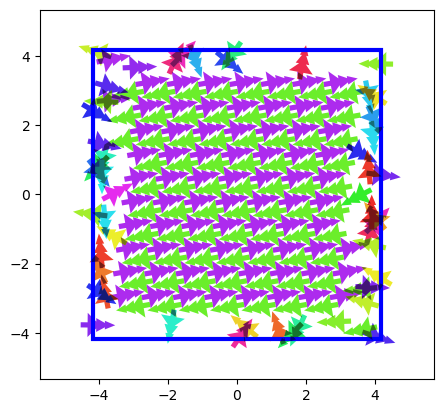

In [6]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_move
import pack_ga3
import pack_runner
importlib.reload(pack_ga3)
fastMode = False
kgs.debugging_mode = 2

for N_trees in [200]:
    for seed in range(1):

        runner = pack_ga3.baseline_symmetry_180_tesselated(adapt_moves=True)

        #ref_sol = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N68_seed507_done.pickle')
        #runner.ga.ga_base.initializer.ref_sol = kgs.create_tiled_solution('Perfect dimer', 15,make_symmetric=True, axis1_offset=0., axis2_offset=0.5)
        #runner.ga.ga_base.initializer.ref_sol.xyt[:,:,:2] += cp.array([0.2,0.2])
        # runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Perfect dimer'
        # runner.ga.ga_base.initializer.ref_sol_axis1_offset = 0.
        runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Close under'
        runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.5
        # runner.ga.ga_base.initializer.new_tree_placer = True
        runner.ga.ga_base.initializer.base_solution.edge_spacer = kgs.EdgeSpacerBasic(dist_x = 0.75, dist_y = 0.5, dist_corner=0.)
        #runner.ga.ga_base.initializer.ref_sol_crystal_type = None
        #runner.ga.ga_base.initializer.ref_sol = kgs.dill_load(kgs.code_dir + '/../res/mine.pickle')[0][75]
        #runner.ga.ga_base.initializer.base_solution.edge_spacer.dist_y+=0.5
        # runner.ga.ga_base.initializer.base_solution.filter_move_locations_with_edge_spacer
        runner.ga.ga_base.use_new_ref_score = True
        #runner.ga.ga_base.ref_score_scale = 1.
        #runner.ga.ga_base.initializer.ref_rotate = None
        #runner.ga.ga_base.initializer.ref_sol.canonicalize()
        #runner.ga.ga_base.initializer.ref_N_scaling = 0.5
        #runner.ga.target_score = 0.34

        # for m in runner.ga.ga_base.move.moves[:6]:
        #     #print(m)
        #     m[2] = 0.


        #runner.ga.ga_base.move.moves.append([pack_move.NoOp(), 'NoOp', 1.])
        #print(runner.ga.ga_base.move.moves)

        runner.ga.ga_base.N_trees_to_do = N_trees
        runner.n_generations = 1000
        #runner.ga.ga_base.reset_check_generations = 3
        runner.ga.N = 16
        #runner.ga.allow_reset_ratio = 1.
        runner.diagnostic_plot = True
        runner.seed = seed
        runner.plot_every = 10
        runner.ga.do_legalize = False
        #runner.filter_before_rough = 1.

        #runner.run()

        runner_temp = copy.deepcopy(runner)
        #runner_temp.ga.ga_base.initializer.fixed_h = cp.array([np.sqrt(0.37*runner_temp.ga.ga_base.N_trees_to_do),0,0],dtype=kgs.dtype_cp)
        import pack_vis_sol
        ref_score = 0.317 + 0.206/np.sqrt(runner_temp.ga.ga_base.N_trees_to_do)
        ref_h = np.sqrt(ref_score*runner_temp.ga.ga_base.N_trees_to_do*np.sqrt(runner_temp.ga.ga_base.ref_score_scale))        
        runner_temp.ga.ga_base.initializer.fixed_h = cp.array([ref_h,0,0],dtype=kgs.dtype_cp) 
        sol = runner_temp.ga.ga_base.initializer.initialize_population(10,runner_temp.ga.ga_base.N_trees_to_do)
        if seed==0:
            for i in range(1):
                #pack_vis_sol.pack_vis_sol(sol.genotype, i)
                pack_vis_sol.pack_vis_sol(sol.phenotype, i)
        plt.pause(0.001)

        #runner.run()
        

In [ ]:
f = kgs.dill_load(kgs.code_dir + '/../res/mine.pickle')[0][153]

<Axes: >

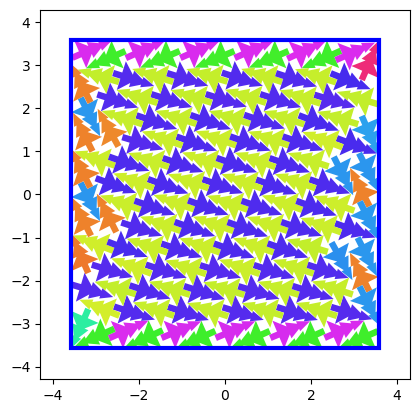

In [ ]:
pack_vis_sol.pack_vis_sol(f,0)
    

In [ ]:
#runner.run()